# Besoin client 2 - prédiction de l'âge 

## I - Préparation des données 

### I. Préparation des données - Import des modules nécessaires

In [13]:
%pip install pandas scikit-learn numpy scipy seaborn joblib matplotlib statsmodels

  Using cached statsmodels-0.14.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.2 kB)
  Using cached patsy-0.5.6-py2.py3-none-any.whl.metadata (3.5 kB)
Using cached statsmodels-0.14.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.7 MB)
Using cached patsy-0.5.6-py2.py3-none-any.whl (233 kB)
Note: you may need to restart the kernel to use updated packages.


In [14]:
# Traitement des données

import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import numpy as np
from scipy.stats import f_oneway
from itertools import combinations
from scipy.stats.mstats import winsorize
import joblib

# Visualisations

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Apprentissage

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

# Métriques

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV

### II. Préparation des données - Import et première analyse des données

In [15]:
# Import de Data_Arbre.csv

arbres_data = pd.read_csv('Data_Arbre.csv')
print(type(arbres_data))

# Analyse 

arbres_data.head(5)
arbres_data.info()
arbres_data.describe()

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7409 entries, 0 to 7408
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   longitude      7409 non-null   float64
 1   latitude       7409 non-null   float64
 2   clc_quartier   7409 non-null   object 
 3   clc_secteur    7409 non-null   object 
 4   haut_tot       7409 non-null   float64
 5   haut_tronc     7409 non-null   float64
 6   tronc_diam     7409 non-null   float64
 7   fk_arb_etat    7409 non-null   object 
 8   fk_stadedev    7409 non-null   object 
 9   fk_port        7409 non-null   object 
 10  fk_pied        7409 non-null   object 
 11  fk_situation   7409 non-null   object 
 12  fk_revetement  7409 non-null   object 
 13  age_estim      7409 non-null   float64
 14  fk_prec_estim  7409 non-null   float64
 15  clc_nbr_diag   7409 non-null   float64
 16  fk_nomtech     7409 non-null   object 
 17  villeca       

,longitude,latitude,haut_tot,haut_tronc,tronc_diam,age_estim,fk_prec_estim,clc_nbr_diag
count,7409.000000,7409.000000,7409.000000,7409.000000,7409.000000,7409.000000,7409.000000,7409.000000
mean,3.295106,49.851217,11.684640,2.833035,104.818194,33.928600,8.289378,0.107032
std,0.015222,0.010433,6.172909,1.789479,59.038210,19.547318,4.784638,0.382551
min,3.247694,49.828030,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.288217,49.842844,7.000000,2.000000,58.000000,20.000000,5.000000,0.000000
50%,3.298562,49.851228,10.000000,2.000000,100.000000,30.000000,10.000000,0.000000
75%,3.304913,49.860616,16.000000,3.000000,144.000000,45.000000,10.000000,0.000000
max,3.325954,49.869195,37.000000,16.000000,565.000000,200.000000,50.000000,4.000000


### III. Encodage et normalisation des données

In [16]:
arbres_data_qual = arbres_data.select_dtypes(include=['object'])
cols_qual = arbres_data_qual.columns

arbres_data_quant = arbres_data.select_dtypes(include = ['float64', 'int64'])
cols_quant = arbres_data_quant.columns

# arbres_data_quant.info()
# arbres_data_qual.info()

In [17]:
# On normalise les données quantitatives

normalizers = {}  # Dictionary to store the scalers for reuse

for column in arbres_data_quant.columns:
    norm = MinMaxScaler()
    arbres_data_quant[column] = norm.fit_transform(arbres_data_quant[[column]])
    normalizers[column] = norm  # Store the scaler in the normalizers dictionary

joblib.dump(normalizers, 'normalizers.pkl')

arbres_data_quant.head()

# On encode les données qualitatives 

label_encoders = {} # Liste des modèles d'encodage pour les réutiliser
for column in arbres_data_qual.columns:
    lab_encoder = LabelEncoder()
    arbres_data_qual[column] = lab_encoder.fit_transform(arbres_data_qual[column])
    label_encoders[column] = lab_encoder

joblib.dump(label_encoders, 'label_encoders.pkl')

arbres_data_qual.head()

arbres_data = pd.concat([arbres_data_quant, arbres_data_qual], axis=1)
#arbres_data.describe()
#arbres_data.info()

### IV. Préparation des données - Matrice de corrélation

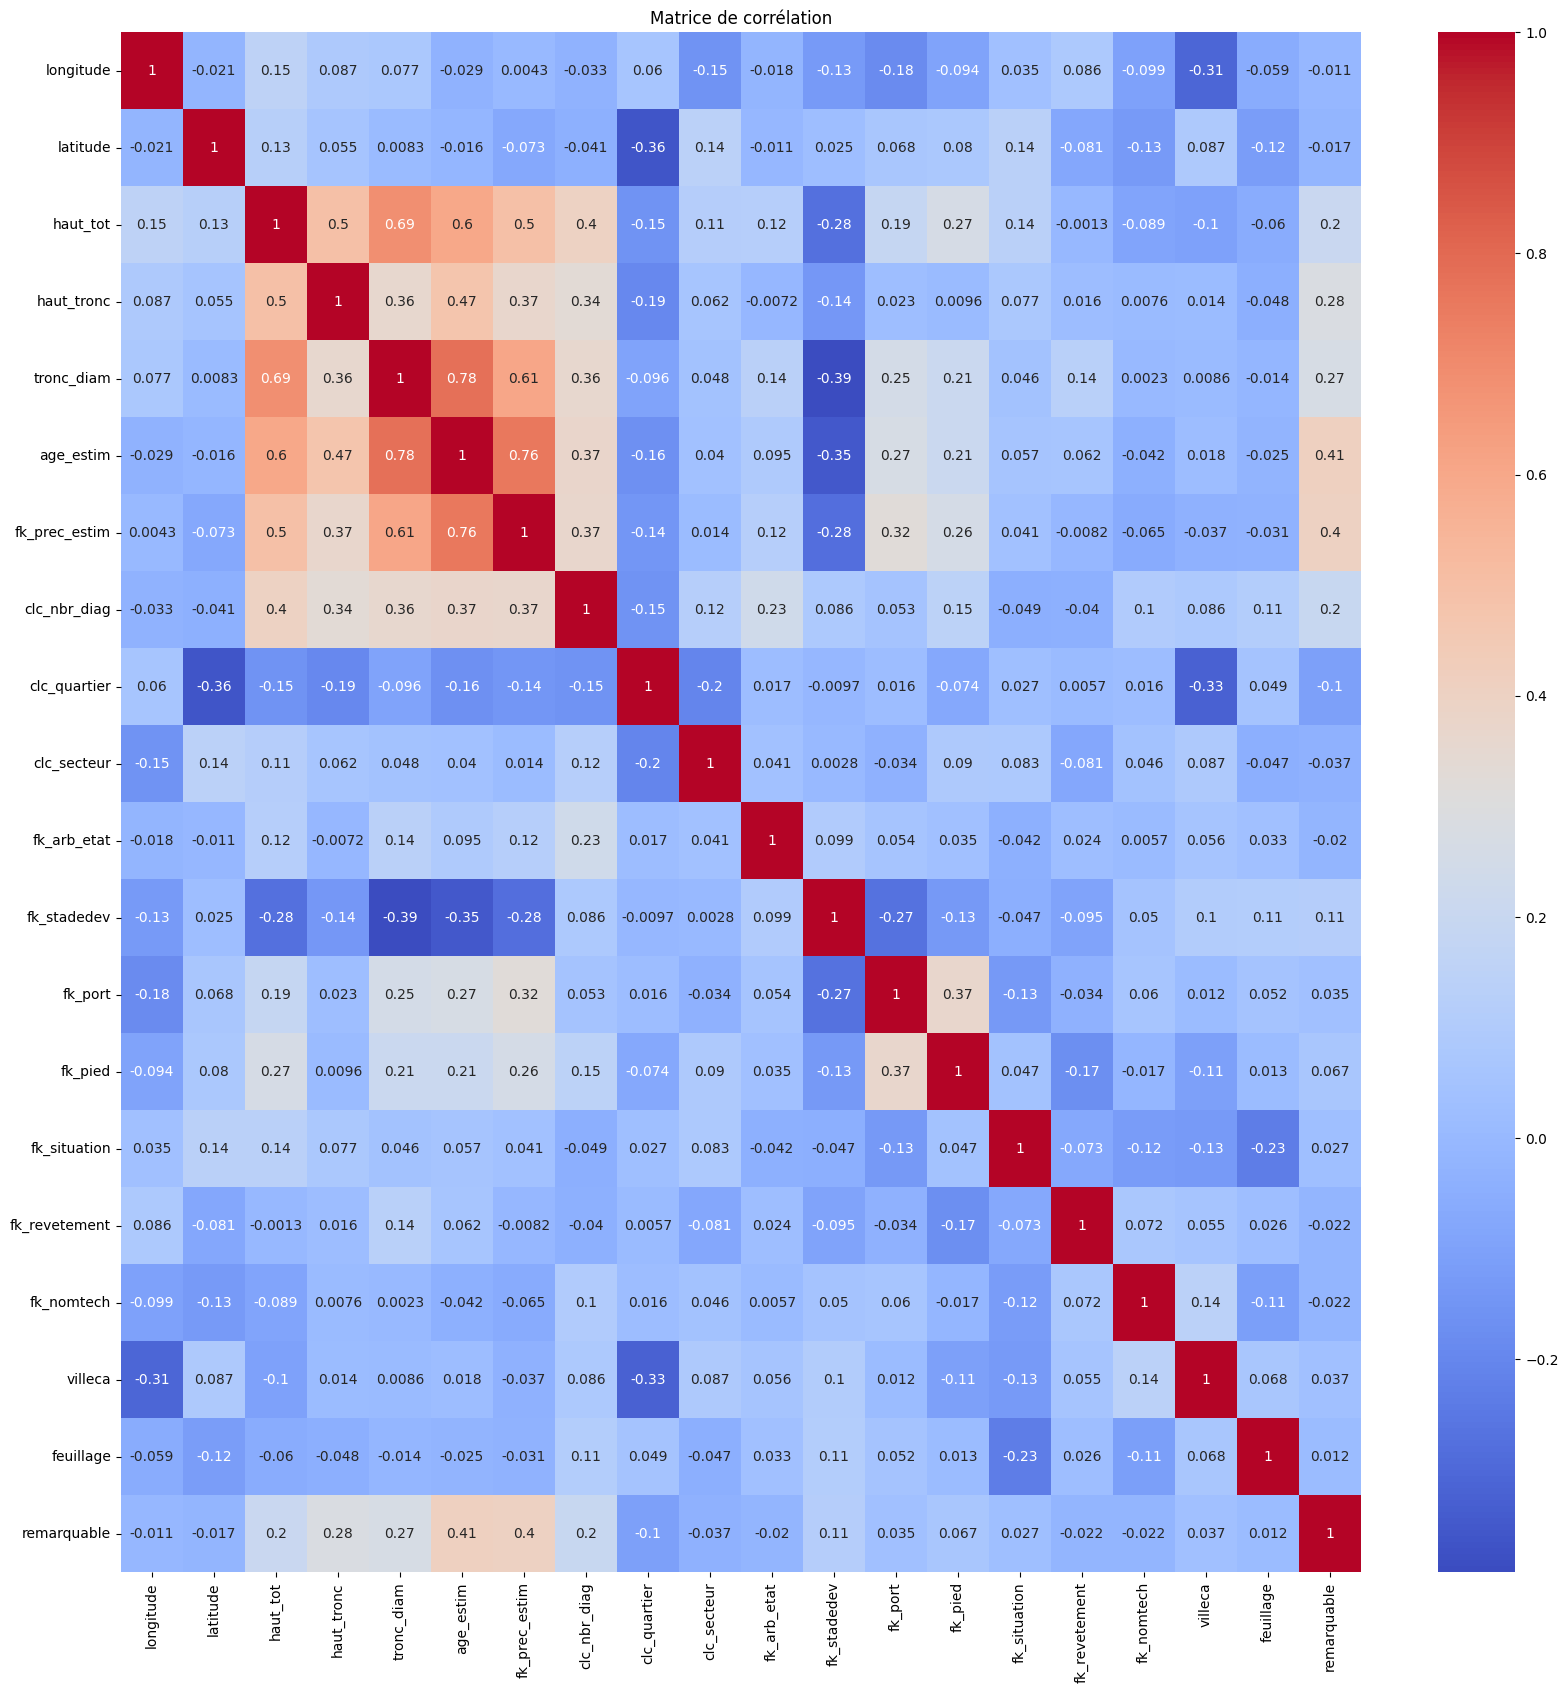

In [18]:
corr_matrix = arbres_data.corr()
#print(corr_matrix["age_estim"])

plt.figure(figsize=(len(arbres_data.columns), len(arbres_data.columns)))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Matrice de corrélation')
plt.savefig("corr_matrix.png")
plt.show()


De par leur coeficient de corrélation avec age_estim : 
- tronc_diam
- fk_prec_estim
- haut_tot
- haut_tronc
- remarquable
- clc_nbr_diag
- fk_stade_dev
  
semblent être les variables avec une corrélation significative ( > |0.3|).

On effectue de plus amples tests afin de vérifier cela.

In [19]:
interesting_cols_quant = ['tronc_diam', 'haut_tot', 'haut_tronc', 'fk_prec_estim', 'clc_nbr_diag', 'age_estim']
interesting_cols_qual = ['remarquable', 'fk_stadedev']

interesting_arbres_data = pd.concat([arbres_data[interesting_cols_quant], arbres_data[interesting_cols_qual]], axis=1)

interesting_arbres_data.describe()

,tronc_diam,haut_tot,haut_tronc,fk_prec_estim,clc_nbr_diag,age_estim,remarquable,fk_stadedev
count,7409.000000,7409.000000,7409.000000,7409.000000,7409.000000,7409.000000,7409.000000,7409.000000
mean,0.185519,0.296796,0.177065,0.165788,0.026758,0.169643,0.014442,0.295856
std,0.104492,0.171470,0.111842,0.095693,0.095638,0.097737,0.119312,0.526240
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.102655,0.166667,0.125000,0.100000,0.000000,0.100000,0.000000,0.000000
50%,0.176991,0.250000,0.125000,0.200000,0.000000,0.150000,0.000000,0.000000
75%,0.254867,0.416667,0.187500,0.200000,0.000000,0.225000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000


### V. Préparation des données - Test ANOVA

In [20]:
# Effectuer l'ANOVA pour les variables utiles afin de confirmer la sélection
anova_results = {}
for quant_col in interesting_cols_quant:
    for qual_col in interesting_cols_qual:
        formula = f'{quant_col} ~ C({qual_col})'
        model = ols(formula, data=interesting_arbres_data).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        anova_results[f'{quant_col} ~ {qual_col}'] = anova_table

# Affichage 
for key, value in anova_results.items():
    print(f'Résultats du test ANOVA pour {key}:\n{value}\n')

Résultats du test ANOVA pour tronc_diam ~ remarquable:
                   sum_sq      df           F         PR(>F)
C(remarquable)   5.790264     1.0  571.121551  1.175721e-121
Residual        75.095194  7407.0         NaN            NaN

Résultats du test ANOVA pour tronc_diam ~ fk_stadedev:
                   sum_sq      df           F  PR(>F)
C(fk_stadedev)  34.445214     3.0  1830.78866     0.0
Residual        46.440243  7405.0         NaN     NaN

Résultats du test ANOVA pour haut_tot ~ remarquable:
                    sum_sq      df           F        PR(>F)
C(remarquable)    8.769074     1.0  310.718357  3.702249e-68
Residual        209.039886  7407.0         NaN           NaN

Résultats du test ANOVA pour haut_tot ~ fk_stadedev:
                    sum_sq      df            F  PR(>F)
C(fk_stadedev)   65.848725     3.0  1069.599566     0.0
Residual        151.960235  7405.0          NaN     NaN

Résultats du test ANOVA pour haut_tronc ~ remarquable:
                   sum_sq    

D'après le test ANOVA, chacune des colonnes sélectionnées semblent être significatives. On visualise donc les données sélectionnées pour le nettoyage final.

### VI. Préparation des données - Visualisation et traitement d'éventuelles valeurs aberrantes
#### Boxplot

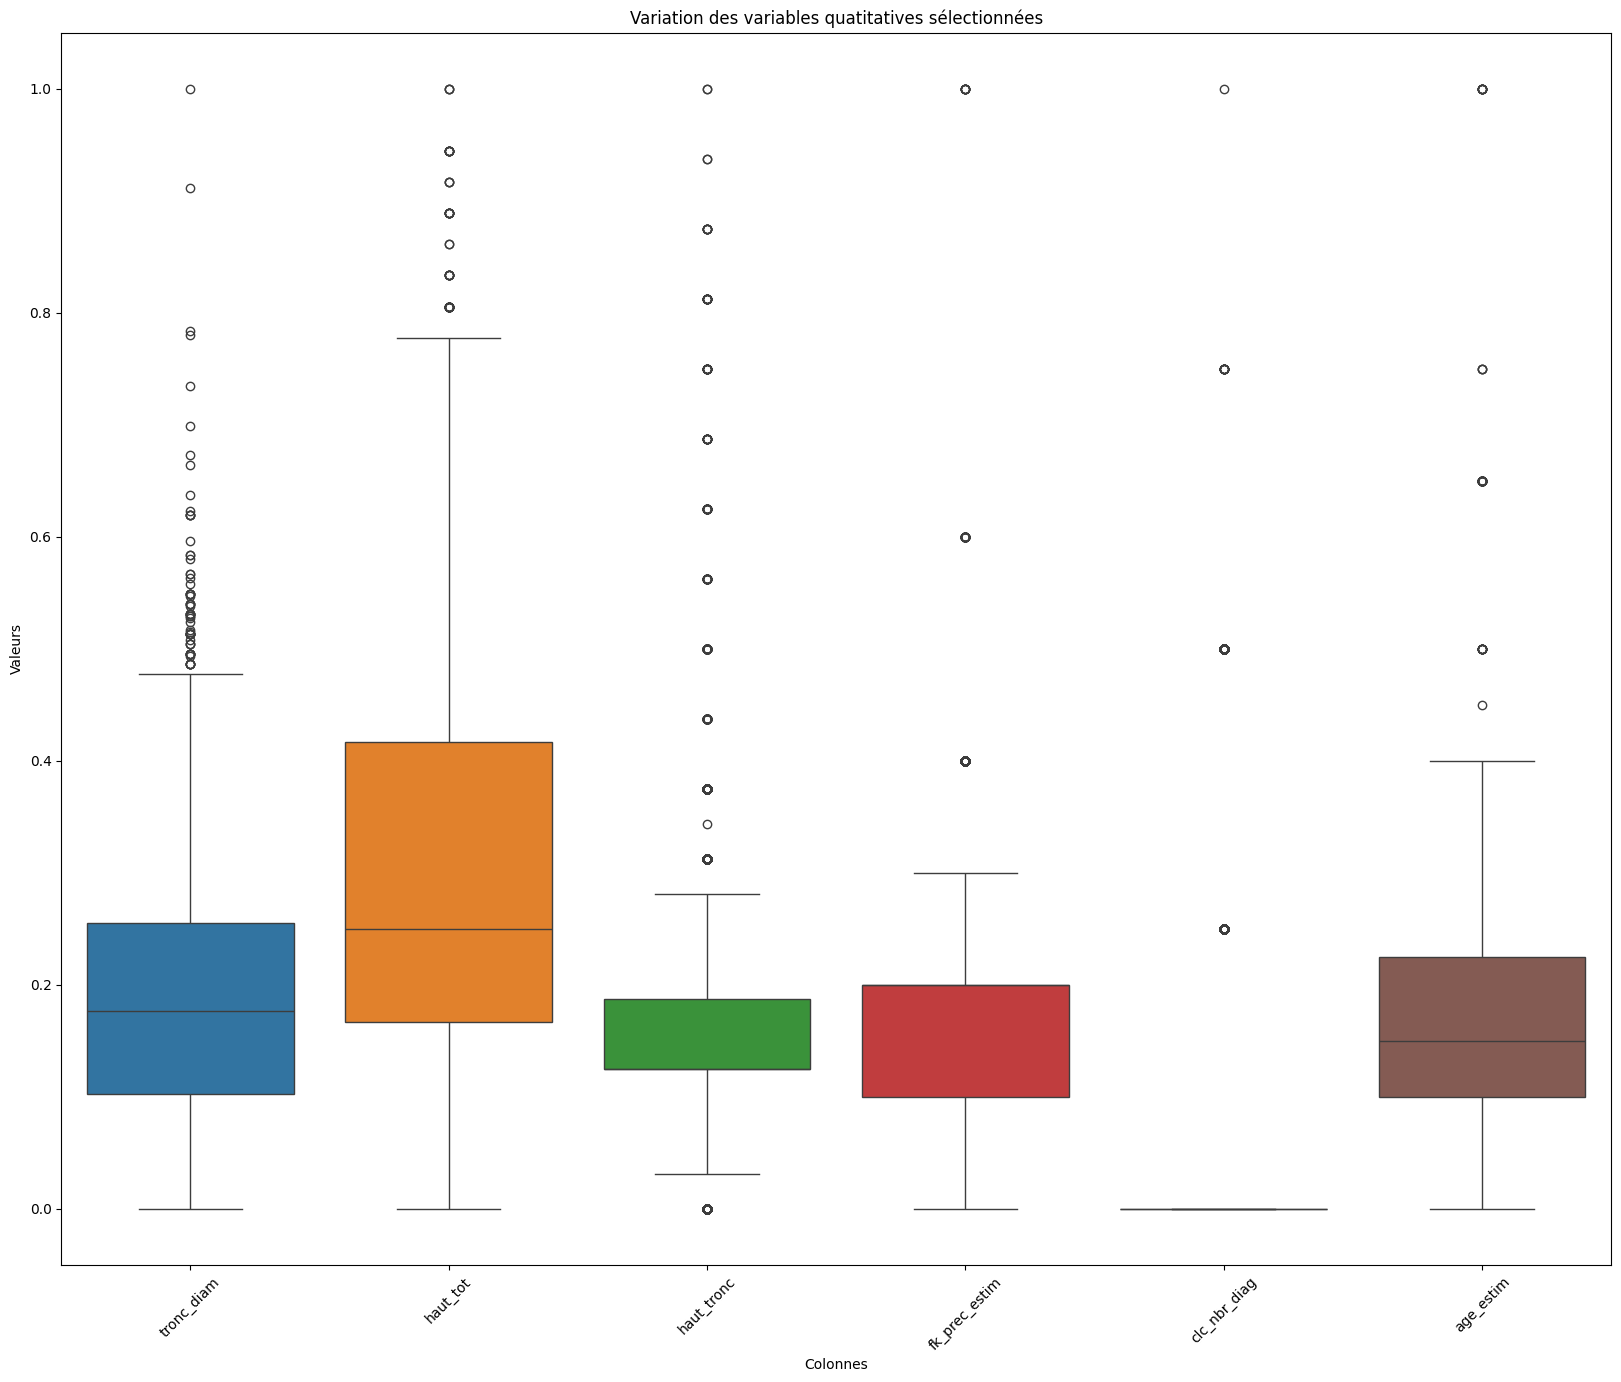

In [21]:
# Diagramme en boîte (boxplot)

def displayBoxplot(data, cols, savefile):
    plt.figure(figsize = (20, 16))
    sns.boxplot(data = data[cols])
    plt.title('Variation des variables quatitatives sélectionnées')
    plt.xlabel('Colonnes')
    plt.ylabel('Valeurs')
    plt.xticks(rotation = 45) 
    plt.savefig(savefile)
    plt.show()

displayBoxplot(interesting_arbres_data, interesting_cols_quant, "boxplot_avant_nettoyage.png")


Après une première analyse, un certain nombre de valeurs aberrantes est détecté. On utilise la Winsorisation afin de ramener celles-ci dans l'écart inter-quartile.

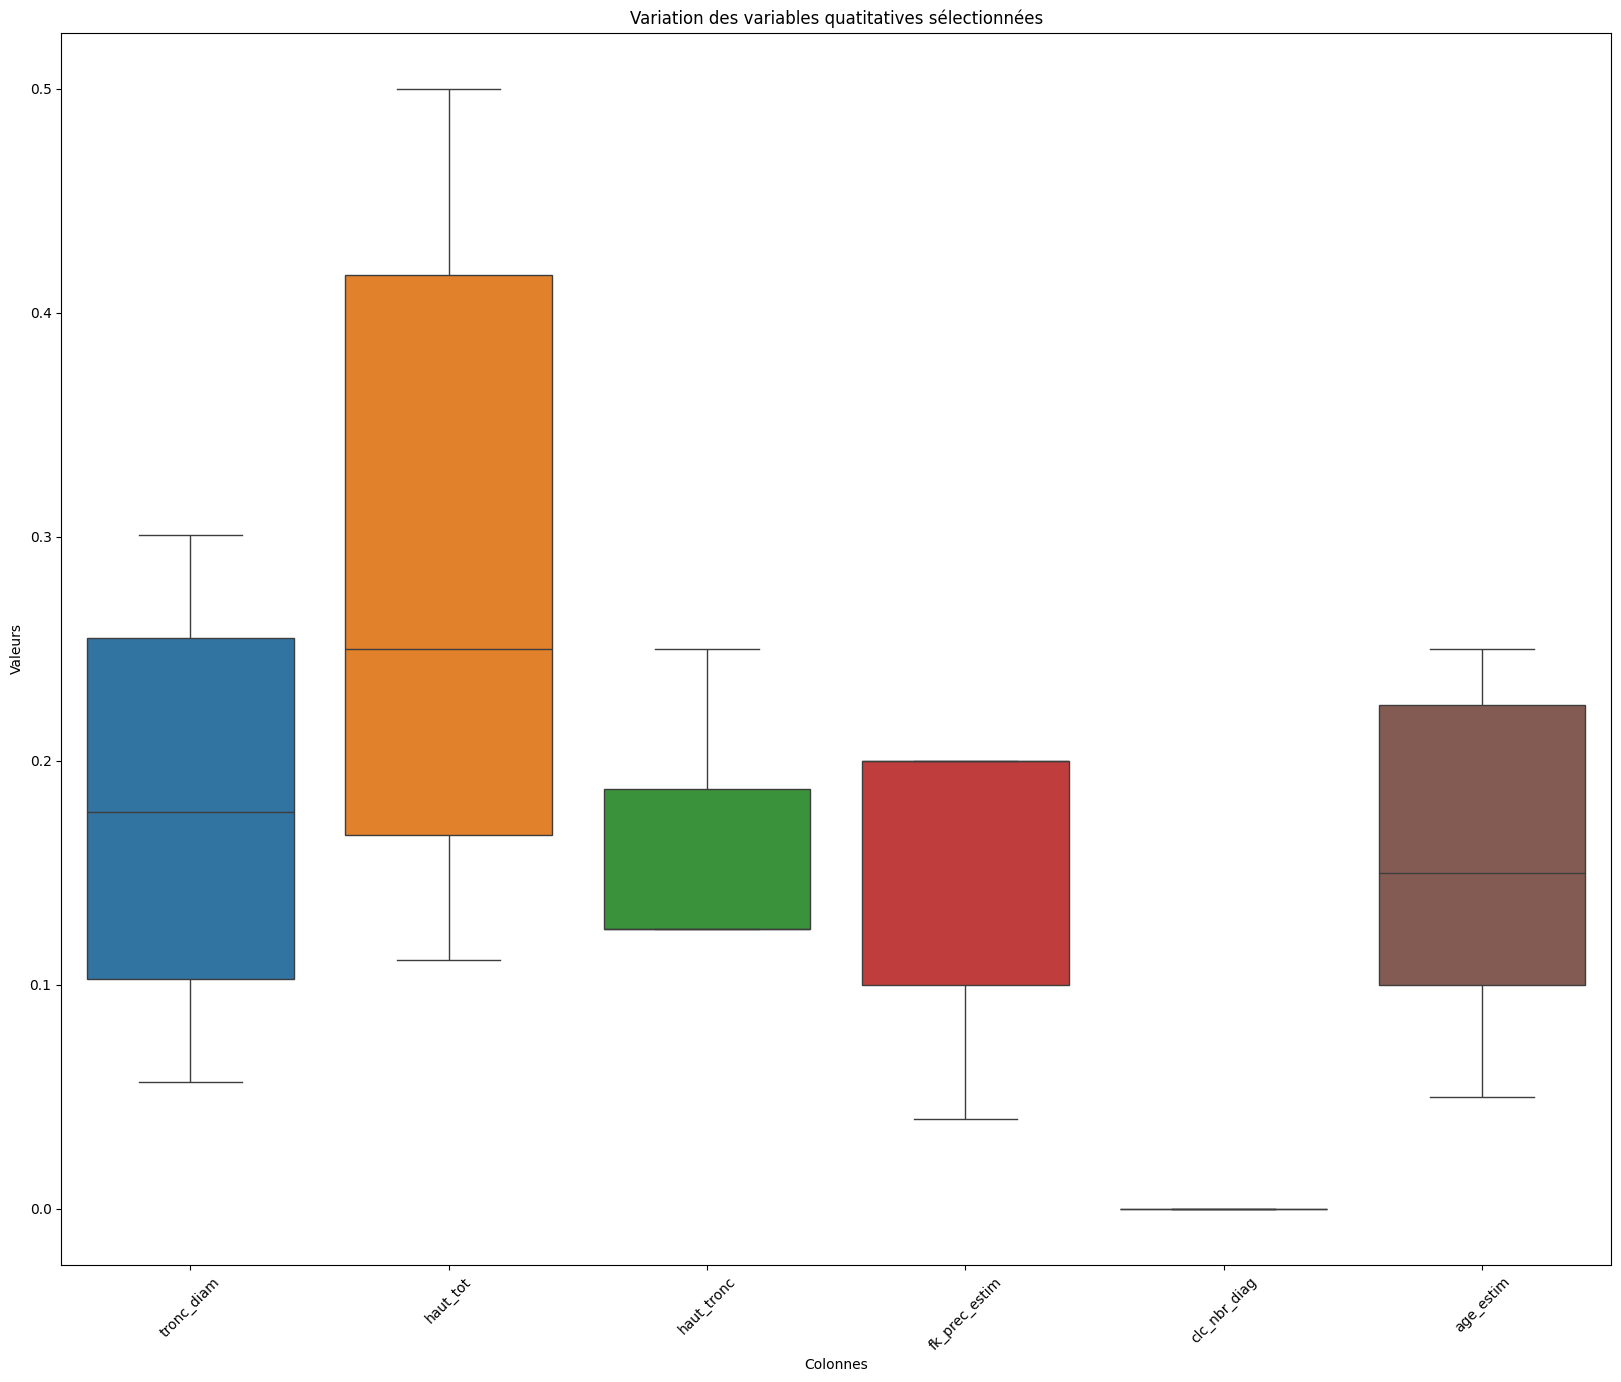

In [22]:
# Bornes déterminées à partir du boxplot

interesting_arbres_data = interesting_arbres_data.apply(lambda col: winsorize(col, limits=[0.13, 0.13]))
displayBoxplot(interesting_arbres_data, interesting_cols_quant, "boxplot_après_nettoyage.png")

#### Histogrammes - visualisation des tendances

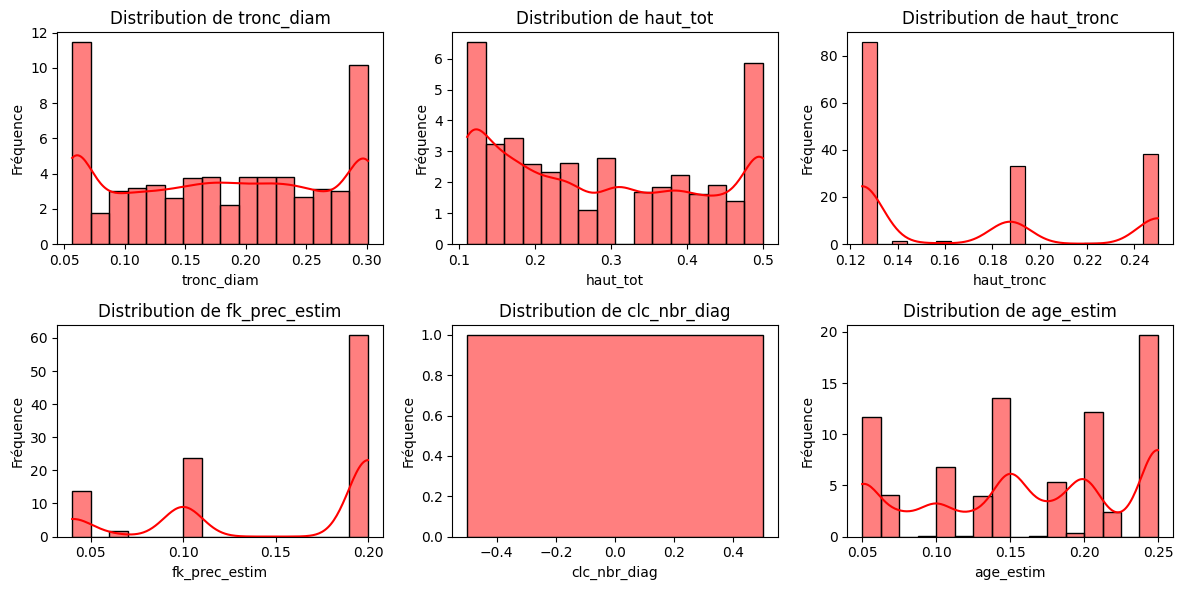

In [23]:
plt.figure(figsize = (12, 6))

for i, col in enumerate(interesting_cols_quant, start=1):
    plt.subplot(2, 3, i)
    sns.histplot(interesting_arbres_data[col], kde=True, color = 'red', stat = 'density')
    plt.title(f'Distribution de {col}')
    plt.xlabel(col)
    plt.ylabel('Fréquence')

plt.tight_layout()
plt.show()

## II - Apprentissage supervisé pour la régression

#### Outils

In [24]:
# Initialiser les modèles

models = {}
    
# Dictionnaire pour stocker les résultats
    
accuracy_train = {
    'Model': [],
    'MAE': [],
    'MSE': [],
    'R^2': []
}
    
accuracy_test = {
    'Model': [],
    'MAE': [],
    'MSE': [],
    'R^2': []
}

def applyModel(name, model):
    # Entraîner le modèle
    model.fit(X_train, y_train)

    # Faire des prédictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Évaluer le modèle
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)

    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    
    # Stocker les résultats dans un dictionnaire
    results = {
        'model': model,
        'y_pred_train': y_pred_train,
        'y_pred_test': y_pred_test,
        'mse_train': mse_train,
        'mse_test': mse_test,
        'mae_train': mse_train,
        'mae_test': mse_test,
        'r2_train': r2_train,
        'r2_test': r2_test
    }
    
    # Afficher les résultats
    print(f"{name} - Train Mean Squared Error: {mse_train}")
    print(f"{name} - Test Mean Squared Error: {mse_test}\n")
    print(f"{name} - Train R^2 Score: {r2_train}")
    print(f"{name} - Test R^2 Score: {r2_test}\n")
    print(f"{name} - Train Mean Absolute Error: {mae_train}")
    print(f"{name} - T Mean Absolute Error: {mae_test}\n")

    models[model] = name
    
    accuracy_train['Model'].append(name)
    accuracy_train['MAE'].append(mae_train)
    accuracy_train['MSE'].append(mse_train)
    accuracy_train['R^2'].append(r2_train)

    accuracy_test['Model'].append(name)
    accuracy_test['MAE'].append(mae_test)
    accuracy_test['MSE'].append(mse_test)
    accuracy_test['R^2'].append(r2_test)
        
    return results



def displayAccuracy(df, savefile):
    plt.figure(figsize=(26, 22))
    metrics = ['MAE', 'MSE', 'R^2']
    
    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 2, i)
        sns.barplot(x='Model', y = metric, data = df, hue = metric)
        plt.title(f'Comparaison des modèles par {metric}')
        plt.xlabel('Modèle')
        plt.ylabel(metric)
        
    plt.savefig(savefile)
    plt.tight_layout()
    plt.show() 

### I. Apprentissage supervisé pour la régression - Séparation des données

In [25]:
# Découpage des données en une base de test (20%) et une base d'apprentissage (80%)

X = interesting_arbres_data.drop(['age_estim'], axis = 1)
y = interesting_arbres_data['age_estim']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size = 0.2)

#X_train.info()
#y_train.info()

### II. Apprentissage supervisé pour la régression - Application de 3 modèles et analyses de précision

#### GradientBoostingRegressor

In [26]:
gbr = GradientBoostingRegressor()
gbr_results = applyModel("Gradient Boosting Regressor", gbr)

Gradient Boosting Regressor - Train Mean Squared Error: 0.001086287284333586
Gradient Boosting Regressor - Test Mean Squared Error: 0.0011560205664663565

Gradient Boosting Regressor - Train R^2 Score: 0.7776012970390256
Gradient Boosting Regressor - Test R^2 Score: 0.7672945519389123

Gradient Boosting Regressor - Train Mean Absolute Error: 0.024582207132615087
Gradient Boosting Regressor - T Mean Absolute Error: 0.025406102631646128



#### RandomForestRegressor

In [27]:
rfr = RandomForestRegressor()
rfr_results = applyModel("Random Forest Regressor", rfr)

Random Forest Regressor - Train Mean Squared Error: 0.0006012001328296337
Random Forest Regressor - Test Mean Squared Error: 0.0012294396183116928

Random Forest Regressor - Train R^2 Score: 0.876914577120083
Random Forest Regressor - Test R^2 Score: 0.7525153915576108

Random Forest Regressor - Train Mean Absolute Error: 0.015889174605496083
Random Forest Regressor - T Mean Absolute Error: 0.02384714493389681



#### KNeighborsRegressor

In [28]:
knn = KNeighborsRegressor()
knn_results = applyModel("KNeighbors Regressor", knn)

KNeighbors Regressor - Train Mean Squared Error: 0.0008700190652944155
KNeighbors Regressor - Test Mean Squared Error: 0.0012431295546558704

KNeighbors Regressor - Train R^2 Score: 0.8218785081411497
KNeighbors Regressor - Test R^2 Score: 0.7497596250398597

KNeighbors Regressor - Train Mean Absolute Error: 0.01999713176986671
KNeighbors Regressor - T Mean Absolute Error: 0.02415789473684211



#### Comparaison de précision - sur la base d'entraînement

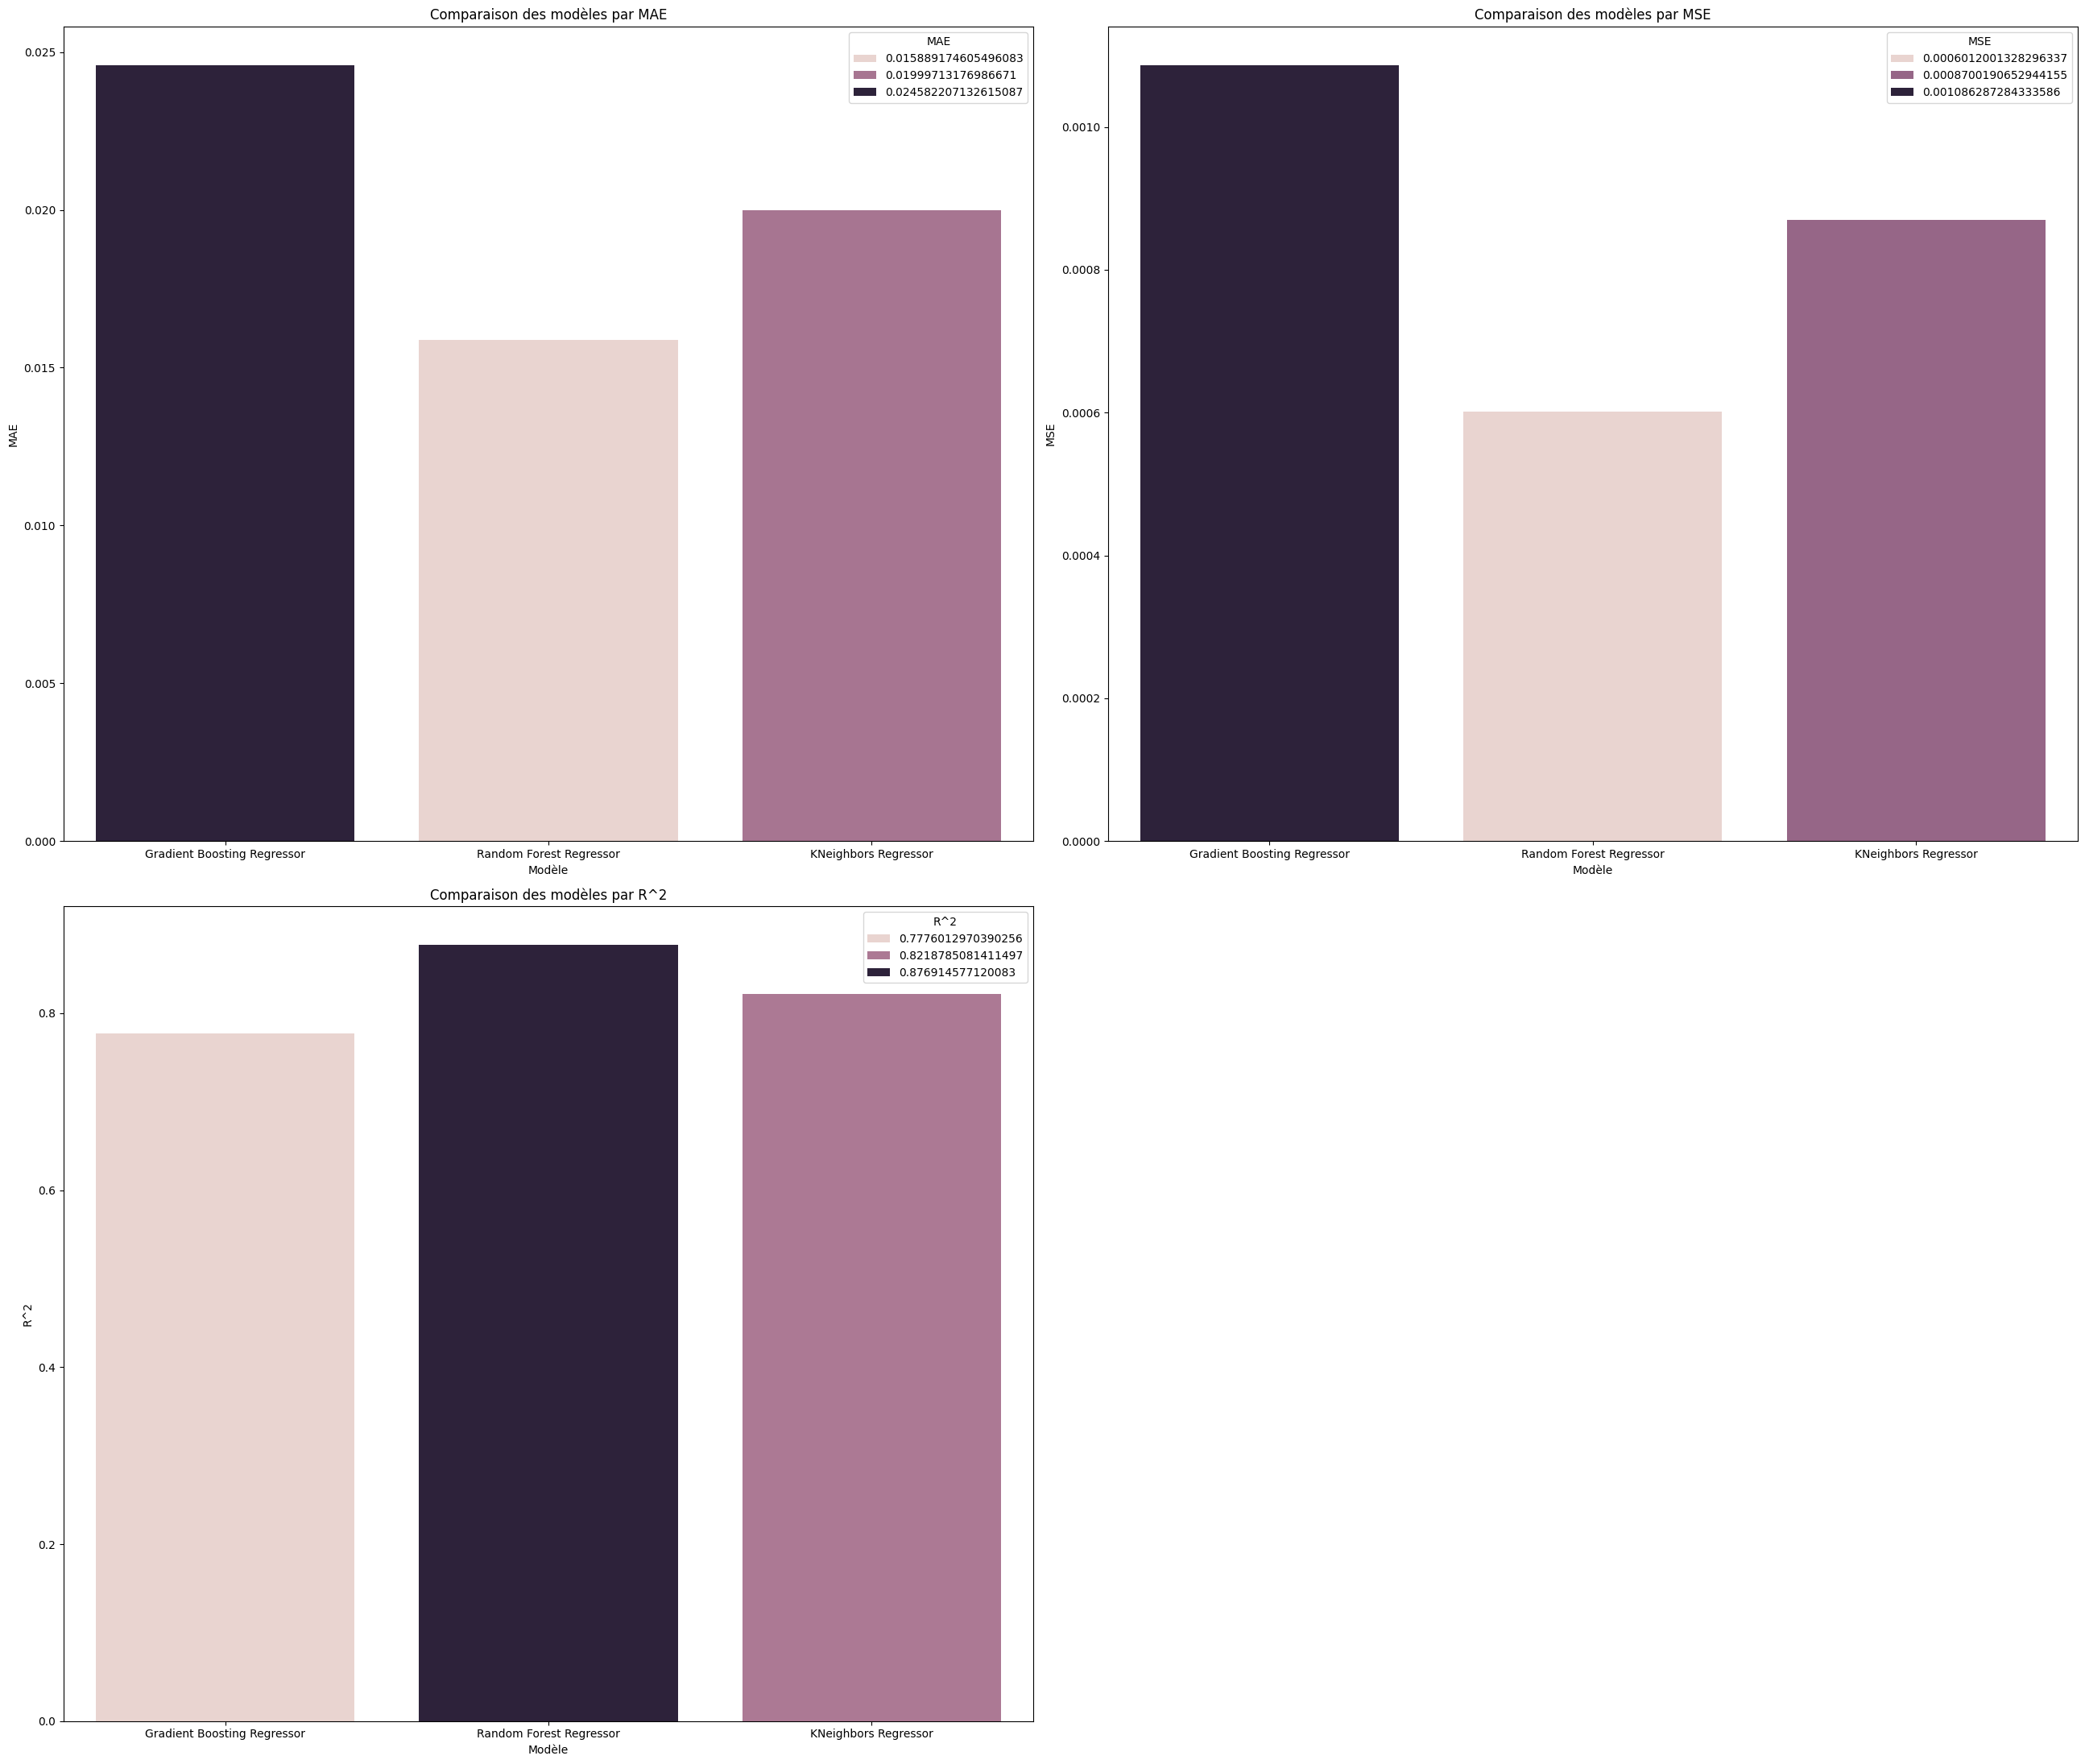

In [29]:
accuracy_train = pd.DataFrame(accuracy_train)
displayAccuracy(accuracy_train, "prec_train_avant_GS.png")

#### Comparaison de précision - sur la base de test

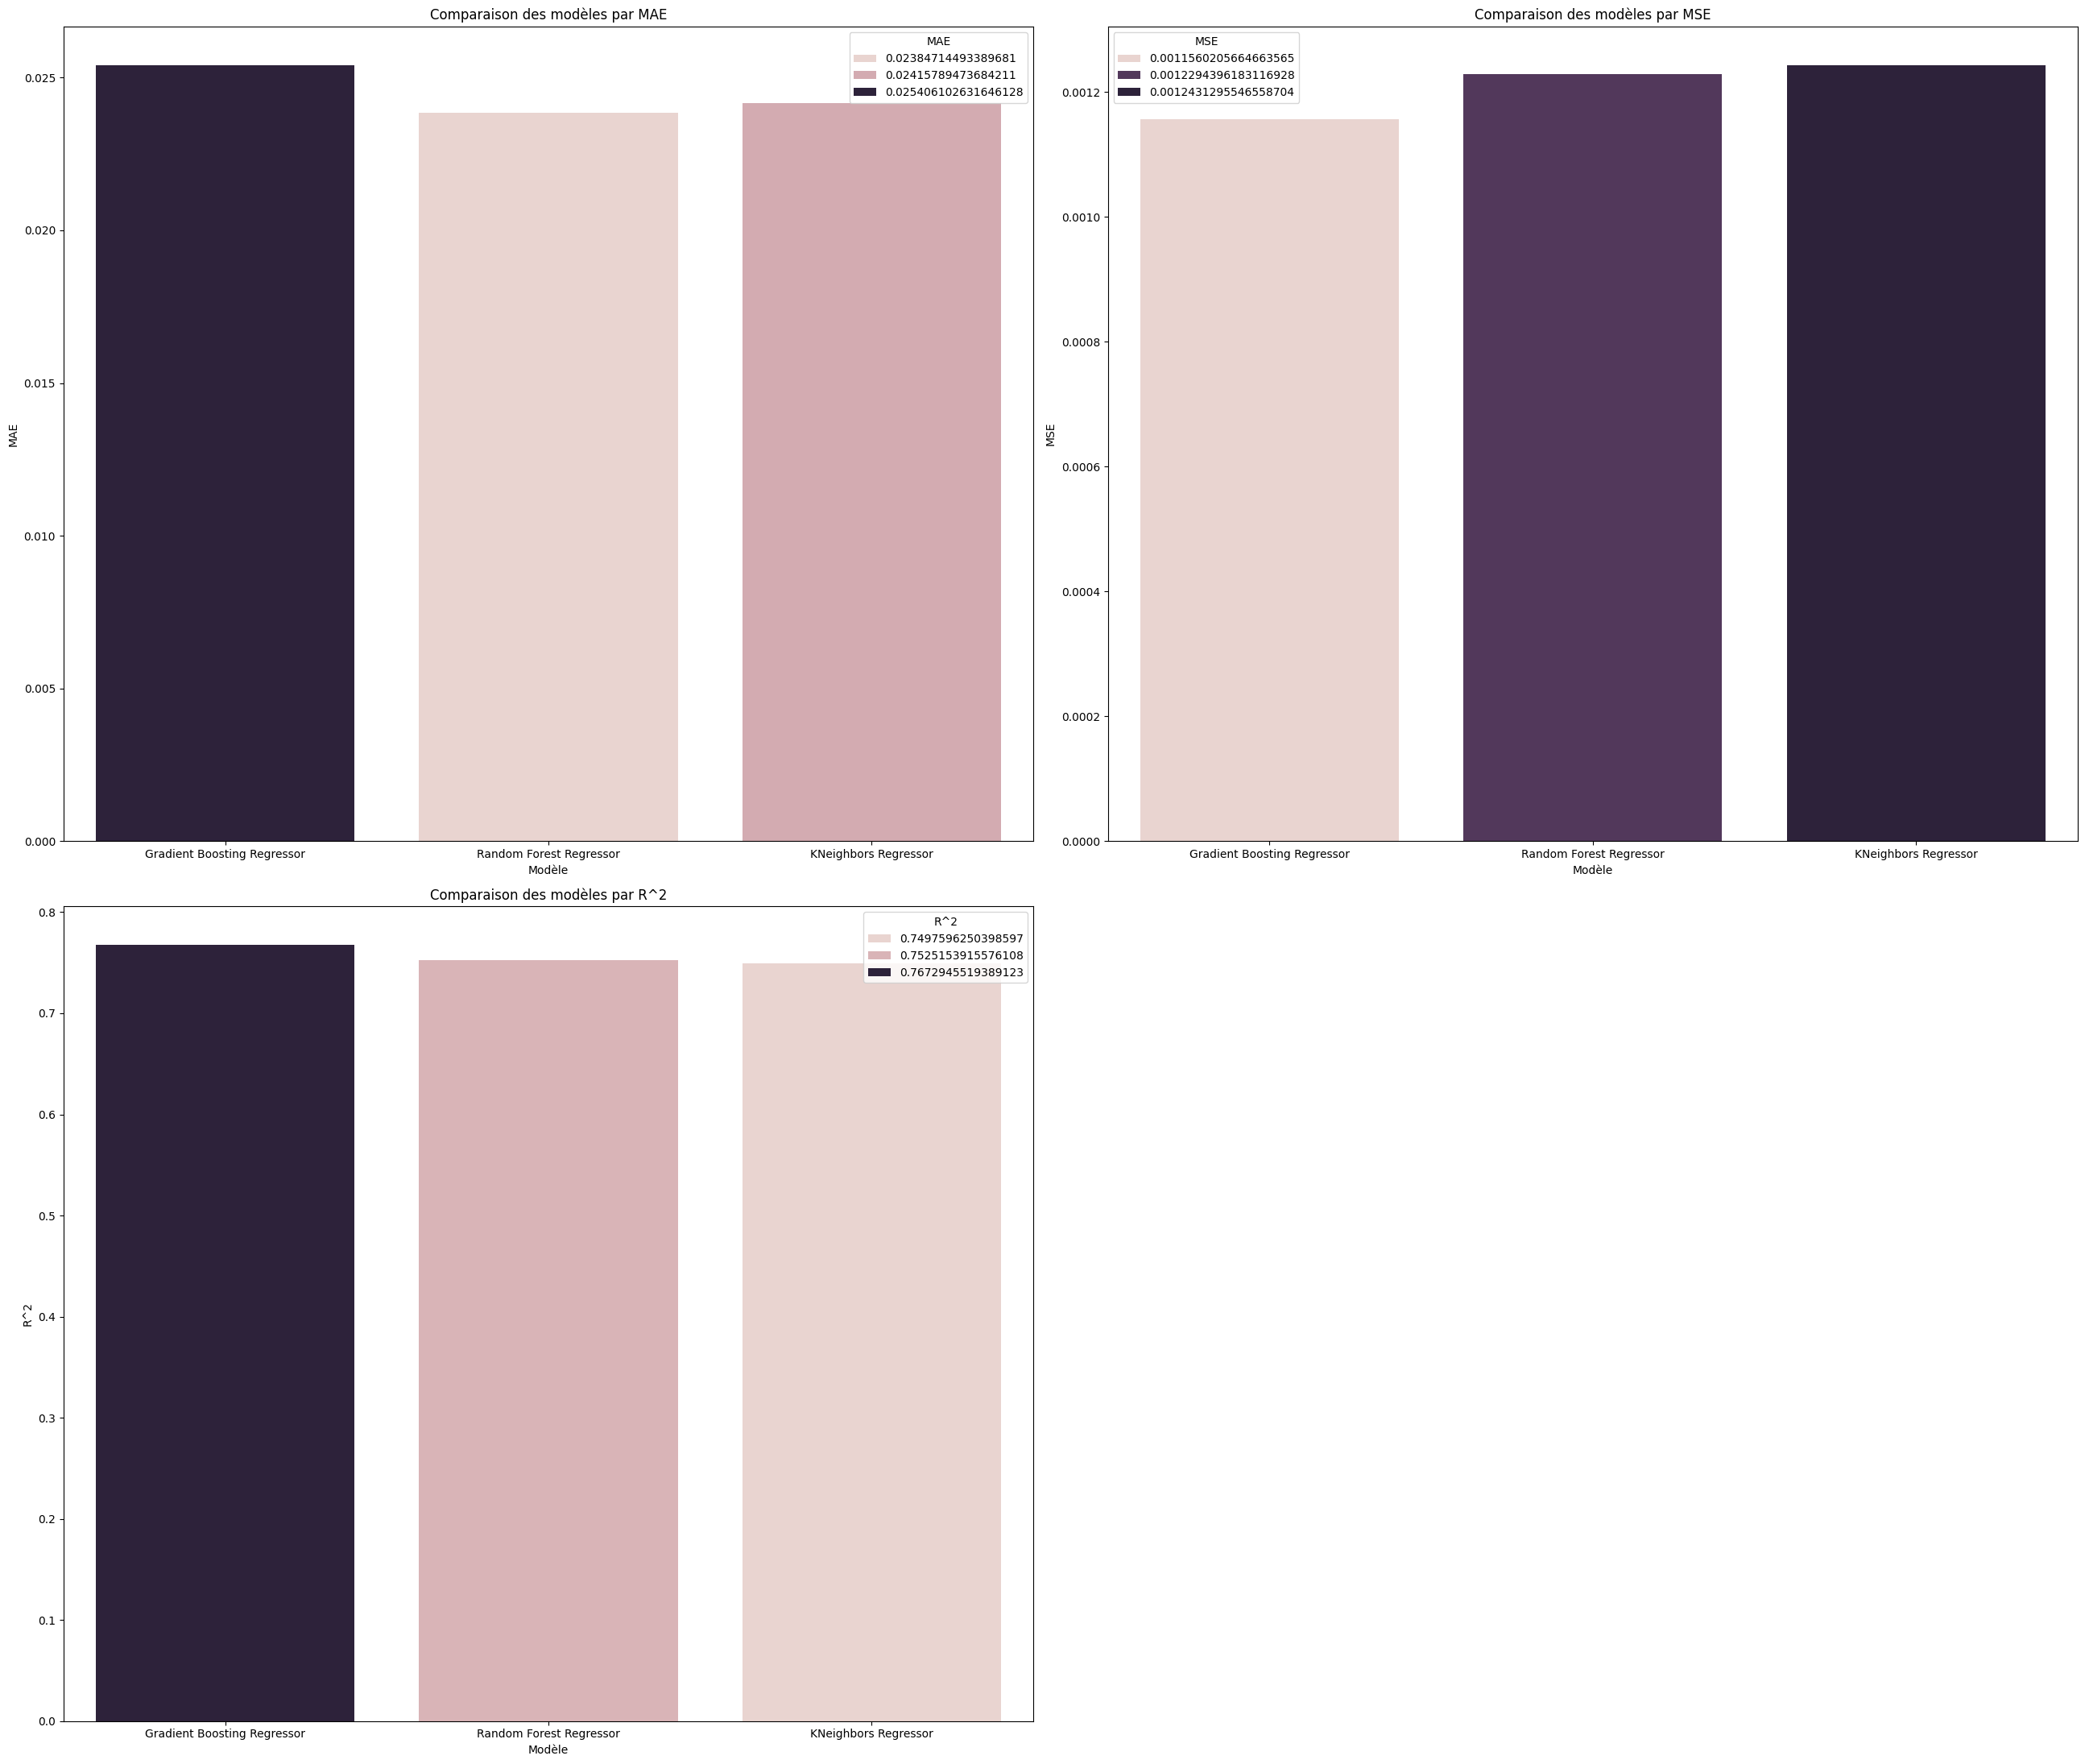

In [30]:
accuracy_test = pd.DataFrame(accuracy_test)
displayAccuracy(accuracy_test, "prec_test_avant_GS.png")

### III - Apprentissage supervisé pour la régression - GridSearch et analyses de la précision des métriques

#### GradientBoostingRegressor

In [31]:
# Définir les paramètres de la grille de base
grid = {
    'n_estimators': [500, 700],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 0.9],
    'max_depth': [7, 9]
}

grid_search = GridSearchCV(gbr, grid, cv = 3, scoring = "neg_mean_squared_error", n_jobs = -1).fit(X_train, y_train)

# Résumer le meilleur score et la meilleure configuration
print("Meilleur score: %f utilisant les paramètres %s" % (grid_search.best_score_, grid_search.best_params_))


Meilleur score: -0.001128 utilisant les paramètres {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.8}


On peut donc en déduire que la meilleure combinaison est : GradientBoostingRegressor(learning_rate = 0.01, max_depth = 7, n_estimators = 500, subsample = 0.8)

#### RandomForestRegressor

In [32]:
# Définir les paramètres de la grille de base
grid = {
    'n_estimators': [500, 700],  # Nombre d'arbres dans la forêt
    'max_depth': [5, 10],  # Profondeur maximale des arbres
    'min_samples_split': [5, 6],  # Nombre minimum d'échantillons requis pour diviser un noeud
    'min_samples_leaf': [2, 3]  # Nombre minimum d'échantillons requis à chaque feuille
}

grid_search = GridSearchCV(rfr, grid, cv = 3, scoring = "neg_mean_squared_error", n_jobs = -1).fit(X_train, y_train)

# Résumer le meilleur score et la meilleure configuration
print("Meilleur score: %f utilisant les paramètres %s" % (grid_search.best_score_, grid_search.best_params_))

Meilleur score: -0.001115 utilisant les paramètres {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 700}


On peut donc en déduire que la meilleure combinaison est : RandomForestRegressor(max_depth = 10, min_samples_leaf = 2, min_samples_split = 5, n_estimators = 500)

#### KNeighborsRegressor

In [33]:
# Définir les paramètres de la grille de base
grid = {
    'n_neighbors': [23, 25],  # Nombre de voisins à considérer
    'weights': ['uniform', 'distance'],  # Méthode de pondération des voisins
    'p': [1, 2]  # Paramètre de puissance pour la distance (1 pour la distance de Manhattan, 2 pour la distance euclidienne)
}

grid_search = GridSearchCV(knn, grid, cv = 3, scoring = "neg_mean_squared_error", n_jobs = -1).fit(X_train, y_train)

# Résumer le meilleur score et la meilleure configuration
print("Meilleur score: %f utilisant les paramètres %s" % (grid_search.best_score_, grid_search.best_params_))

Meilleur score: -0.001141 utilisant les paramètres {'n_neighbors': 25, 'p': 2, 'weights': 'uniform'}


On peut donc en déduire que la meilleure combinaison est : KNeighborsRegressor(n_neighbors = 23, p = 1, weights = 'uniform')

#### Comparaison de précision - sur la base d'entraînement

In [34]:
models = {}
    
# Dictionnaire pour stocker les résultats
    
accuracy_train = {
    'Model': [],
    'MAE': [],
    'MSE': [],
    'R^2': []
}
    
accuracy_test = {
    'Model': [],
    'MAE': [],
    'MSE': [],
    'R^2': []
}

gbr = GradientBoostingRegressor(learning_rate = 0.01, max_depth = 7, n_estimators = 500, subsample = 0.8)
rfr = RandomForestRegressor(max_depth = 10, min_samples_leaf = 2, min_samples_split = 5, n_estimators = 500)
knn = KNeighborsRegressor(n_neighbors = 23, p = 1, weights = 'uniform')

gbr_results = applyModel("Gradient Boosting Regressor", gbr)
rfr_results = applyModel("Random Forest Regressor", rfr)
knn_results = applyModel("KNeighbors Regressor", knn)


Gradient Boosting Regressor - Train Mean Squared Error: 0.0007935246228162529
Gradient Boosting Regressor - Test Mean Squared Error: 0.00108943822154593

Gradient Boosting Regressor - Train R^2 Score: 0.8375394341560418
Gradient Boosting Regressor - Test R^2 Score: 0.7806974920397333

Gradient Boosting Regressor - Train Mean Absolute Error: 0.02009654363667328
Gradient Boosting Regressor - T Mean Absolute Error: 0.02377959180918304

Random Forest Regressor - Train Mean Squared Error: 0.0008448163268152341
Random Forest Regressor - Test Mean Squared Error: 0.001101280470875906

Random Forest Regressor - Train R^2 Score: 0.8270383368804443
Random Forest Regressor - Test R^2 Score: 0.7783136625333026

Random Forest Regressor - Train Mean Absolute Error: 0.020395953003043723
Random Forest Regressor - T Mean Absolute Error: 0.02346659812325981

KNeighbors Regressor - Train Mean Squared Error: 0.0010267443482981187
KNeighbors Regressor - Test Mean Squared Error: 0.0011478443272642856

KNeigh

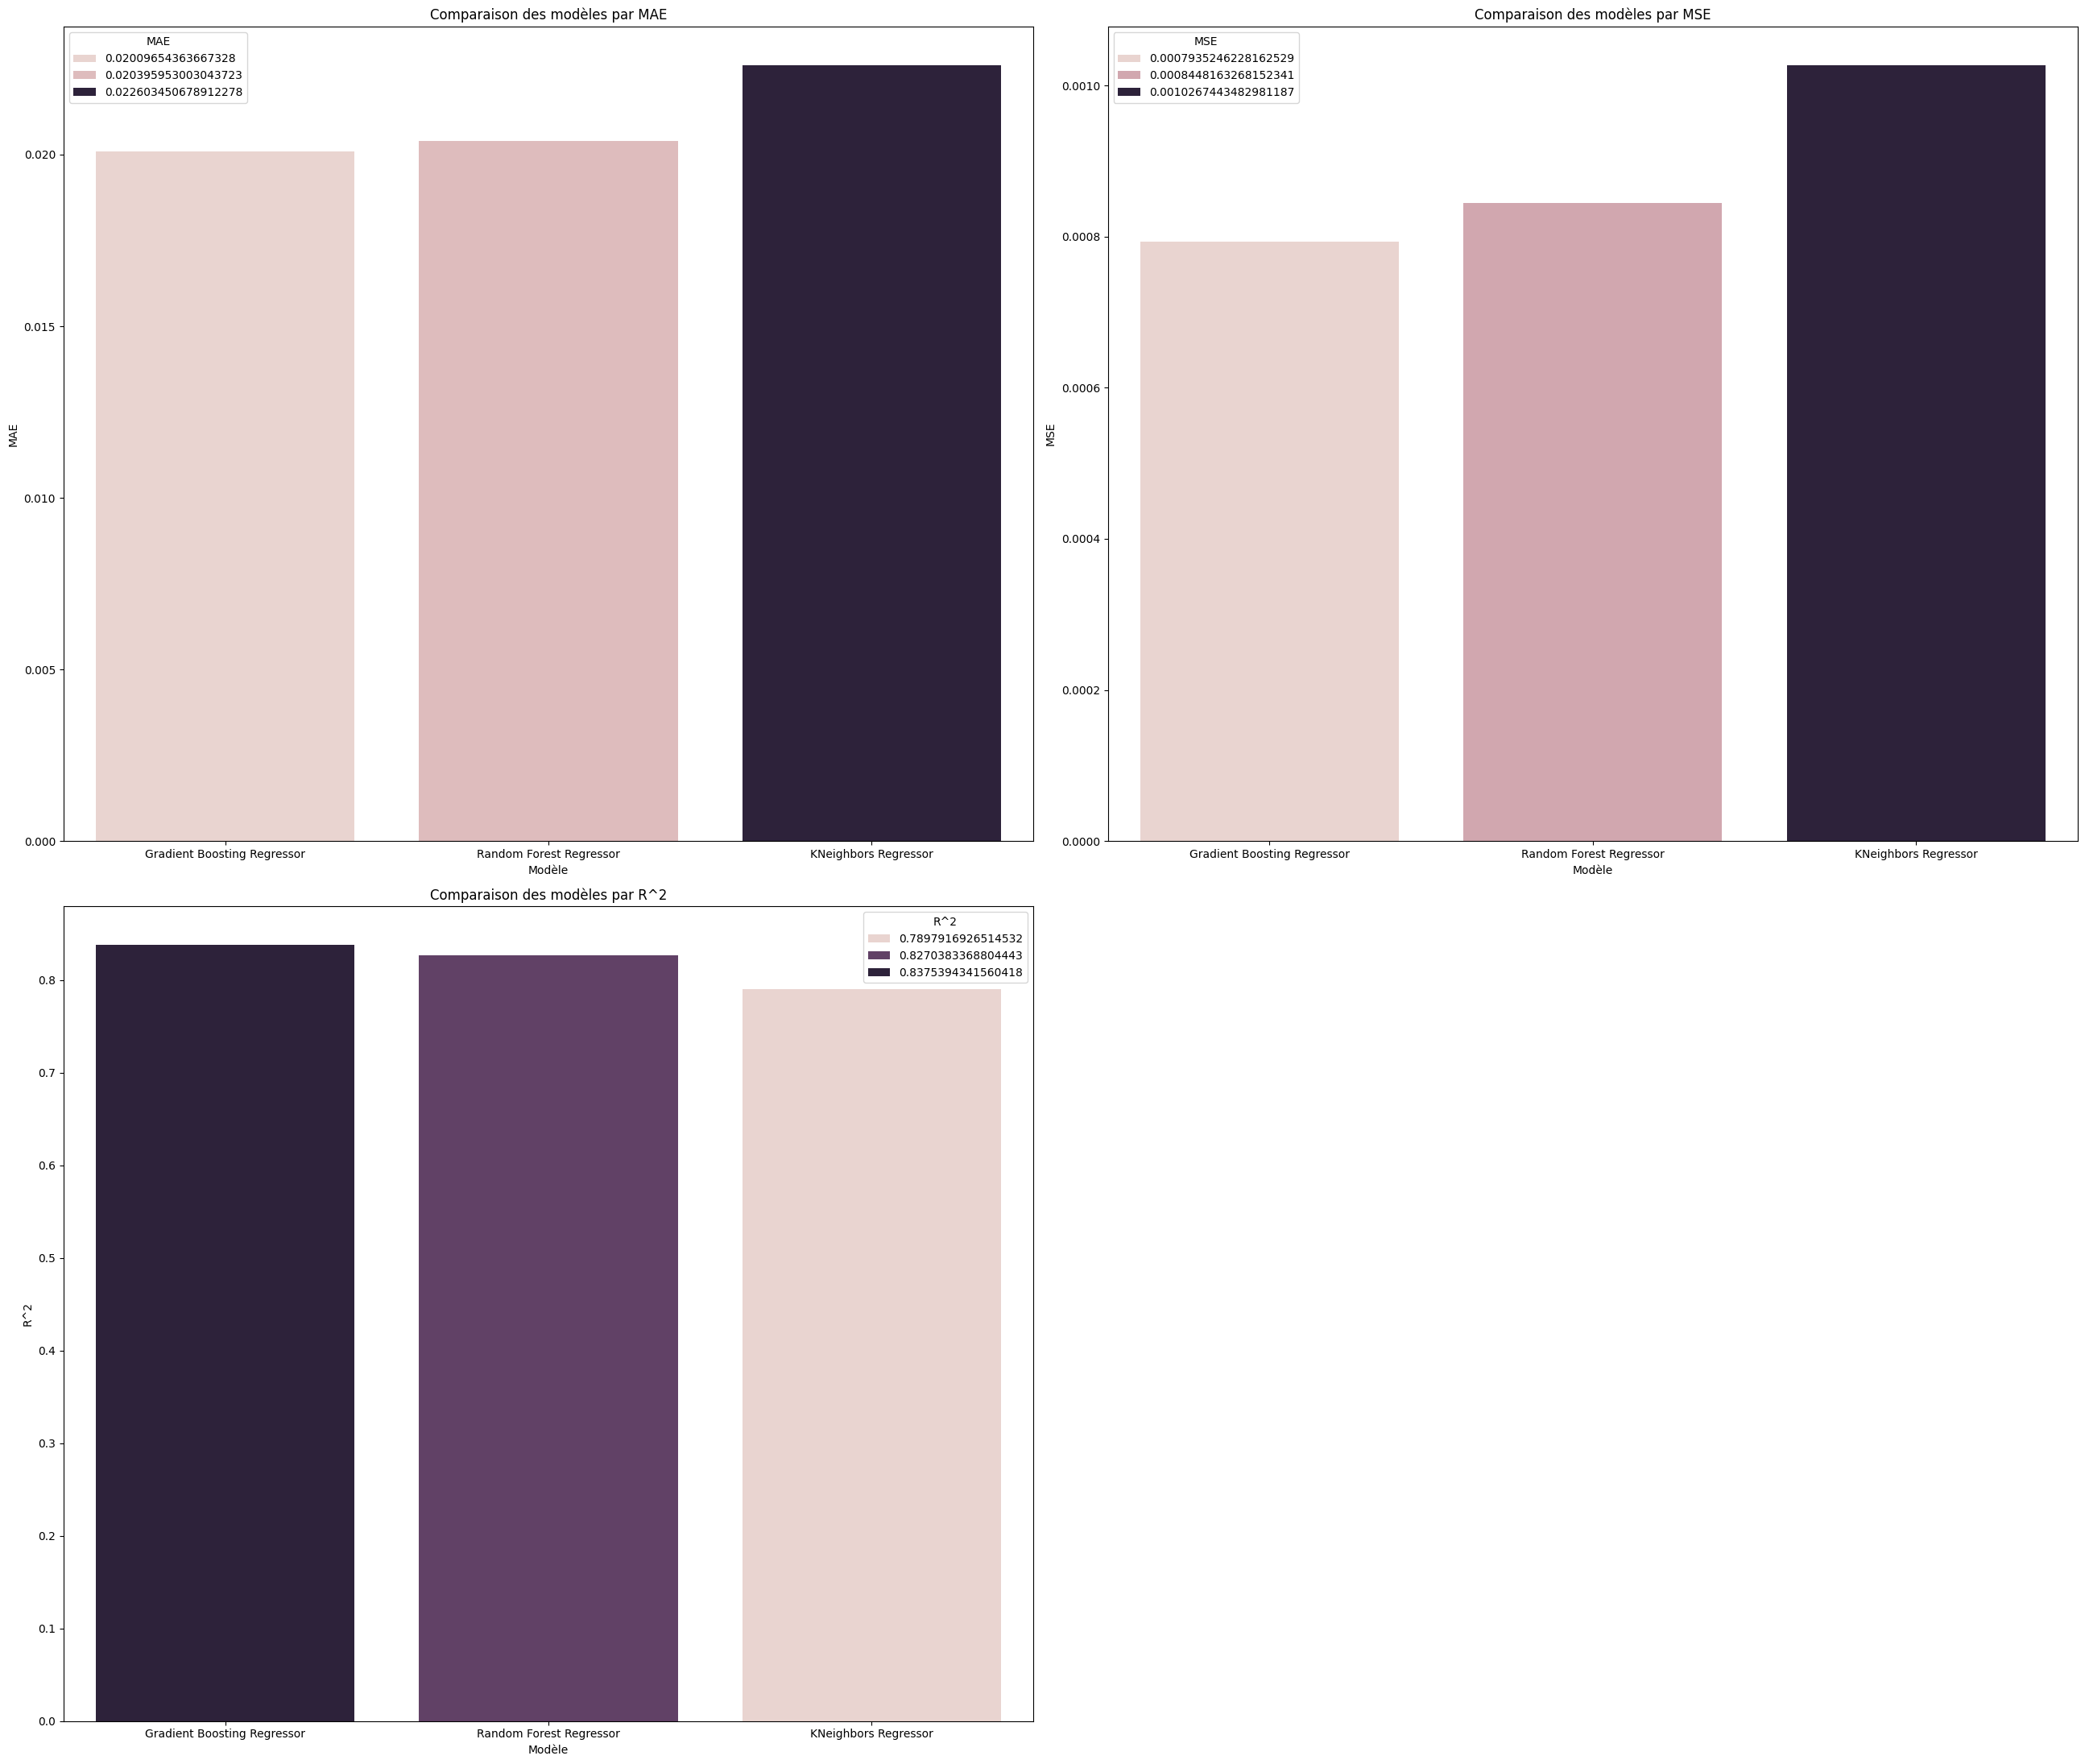

In [35]:
displayAccuracy(accuracy_train, "prec_train_après_GS.png")

#### Comparaison de précision - sur la base de test

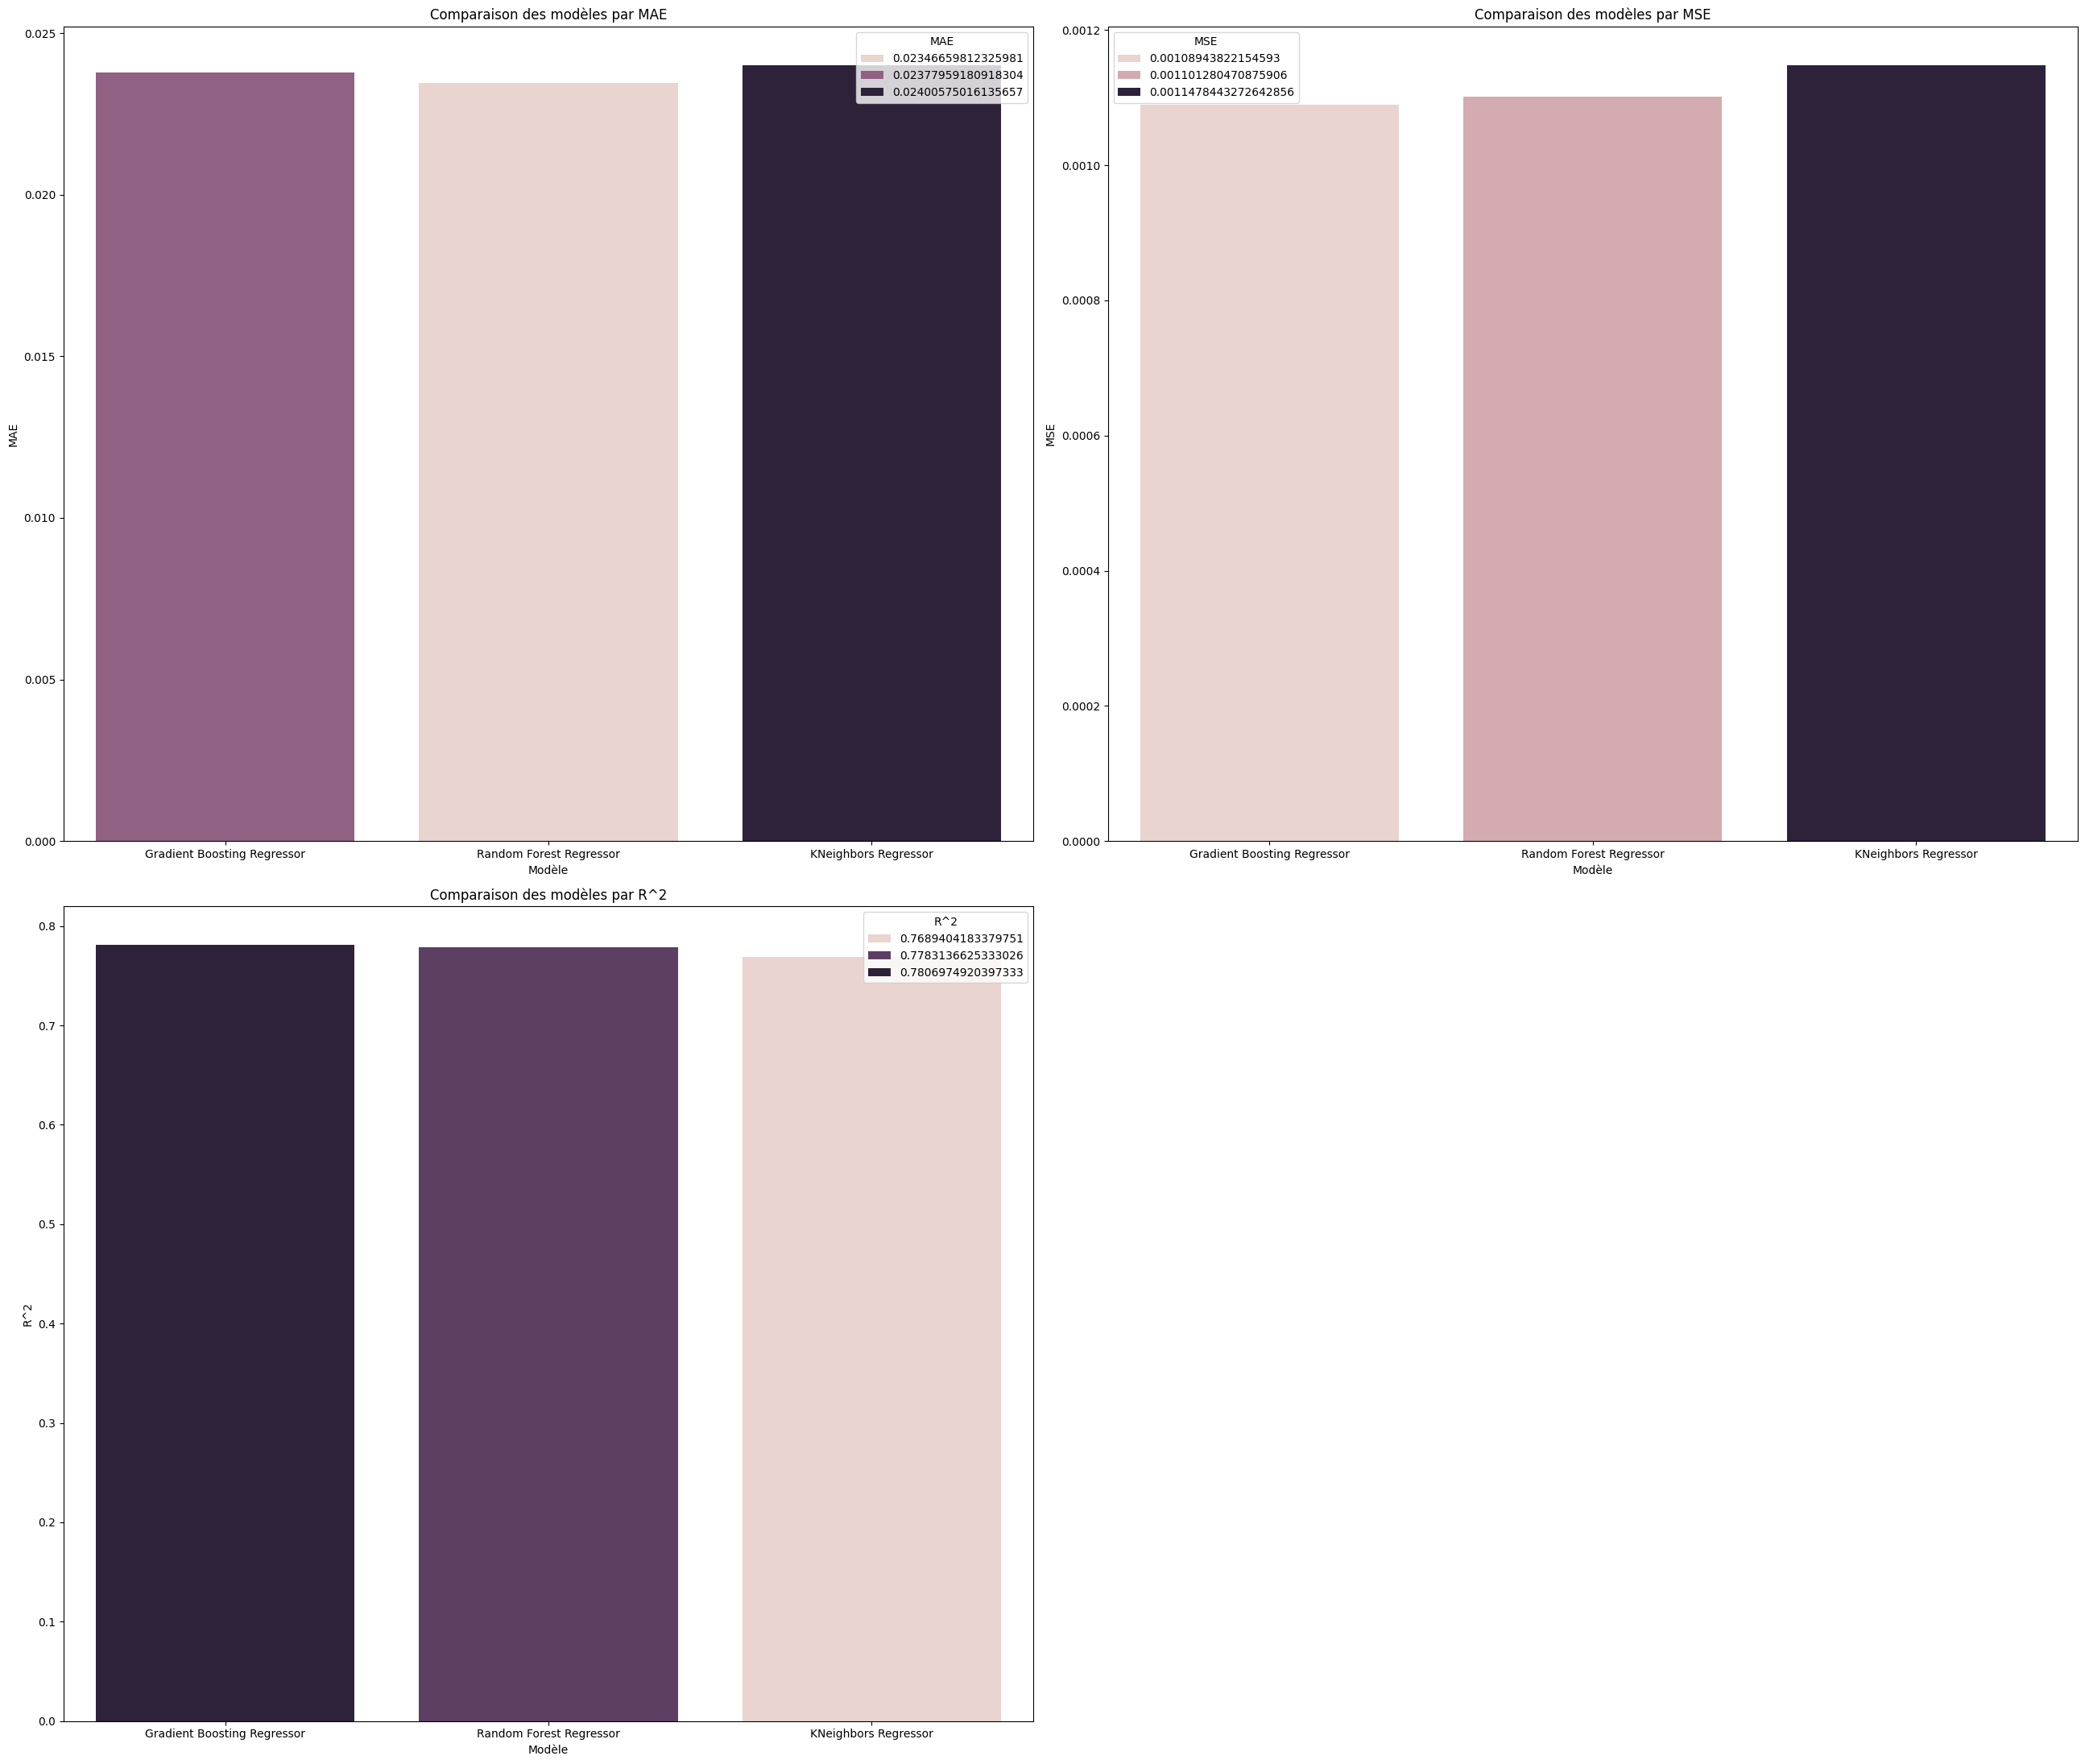

In [36]:
displayAccuracy(accuracy_test, "prec_test_après_GS.png")

D'après les prédictions, on choisit le modèle Gradient Boosting Regressor

## III - Prédiction finale et retour aux données de base - résultat verbeux

In [37]:
best_model = applyModel("Gradient Boosting Regressor", gbr)

# Convert predictions to DataFrame
best_model['y_pred_test'] = pd.DataFrame(best_model['y_pred_test'], columns=['age_estim'])

# Concatenate test features and predictions
arbres_data_pred = pd.concat([X_test.reset_index(drop=True), best_model['y_pred_test']], axis=1)

# Apply inverse transformations for qualitative columns
for col in interesting_cols_qual:
    arbres_data_pred[col] = label_encoders[col].inverse_transform(arbres_data_pred[col])


# Apply inverse transformations for quantitative columns
for col in interesting_cols_quant:
    arbres_data_pred[[col]] = normalizers[col].inverse_transform(arbres_data_pred[[col]])

print(arbres_data_pred)

# Save the best model
best_model_to_save = {'model': best_model['model']}
joblib.dump(best_model_to_save, 'best_model.pkl')


Gradient Boosting Regressor - Train Mean Squared Error: 0.0007933476501901114
Gradient Boosting Regressor - Test Mean Squared Error: 0.0010874486184859308

Gradient Boosting Regressor - Train R^2 Score: 0.837575666268008
Gradient Boosting Regressor - Test R^2 Score: 0.7810979965679148

Gradient Boosting Regressor - Train Mean Absolute Error: 0.020104346288020172
Gradient Boosting Regressor - T Mean Absolute Error: 0.023756147798990063

      tronc_diam  haut_tot  haut_tronc  fk_prec_estim  clc_nbr_diag  \
0           32.0       7.0         2.0            3.0           0.0   
1          105.0      12.0         2.0           10.0           0.0   
2          170.0      18.0         4.0            2.0           0.0   
3          106.0      12.0         4.0            5.0           0.0   
4           32.0       5.0         2.0            2.0           0.0   
...          ...       ...         ...            ...           ...   
1477       120.0      15.0         2.0           10.0          

['best_model.pkl']

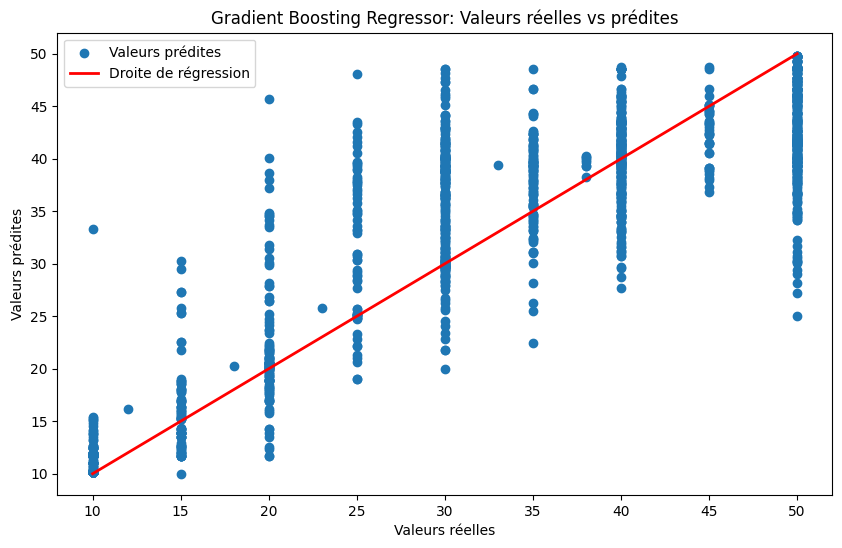

In [38]:
# Plot actual vs. predicted values

y_test = np.array(y_test).reshape(-1, 1)
y_test_inv = normalizers['age_estim'].inverse_transform(y_test)

plt.figure(figsize=(10, 6))
plt.scatter(y_test_inv, arbres_data_pred['age_estim'], label='Valeurs prédites')
plt.plot([min(y_test_inv), max(y_test_inv)], [min(y_test_inv), max(y_test_inv)], color='red', linestyle='-', linewidth=2, label='Droite de régression')
plt.xlabel('Valeurs réelles')
plt.ylabel('Valeurs prédites')
plt.title('Gradient Boosting Regressor: Valeurs réelles vs prédites')
plt.legend()
plt.savefig("Droite_reg_finale.png")
plt.show()
